<a href="https://colab.research.google.com/github/Speech-Emotion-Recognition-ECS-271/Testing/blob/main/ML_SER_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition

- Augmentation (noise & stretch)
- Data preprocessing (duration setting & feature extraction)
- Model (CNN, MLP...)
- Loss & accuracy plot, heatmap, classification report


# library & class define

In [ ]:
pip install audiomentations

In [ ]:
pip install audioread

In [ ]:
!pip install keras.utils

In [21]:
import tensorflow.keras.layers as tfl

In [22]:
import random
import numpy as np
import tensorflow as tf
random.seed(299)
np.random.seed(299)
tf.random.set_seed(299)

In [3]:
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)

# sklearn
from sklearn.preprocessing import LabelEncoder

# Other  
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew

import json
import tensorflow as tf
from matplotlib.pyplot import specgram

import IPython.display as ipd  # To play sound in the notebook

In [4]:
import pandas as pd
import librosa
import librosa.display
import soundfile
import os, glob, pickle, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
# from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [5]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [6]:
## path!

from google.colab import drive
drive.mount('/content/gdrive')

path = 'gdrive/MyDrive/Data/audio_speech_actors_01-24/Actor_*/*.wav' 
path_2 = 'gdrive/MyDrive/Data/Actor_01/*.wav' 

Mounted at /content/gdrive


In [7]:
# path_orig = 'gdrive/MyDrive/data_orig/Audio_Speech_Actors_01-24/Actor_*/*.wav' 
path_orig = 'gdrive/MyDrive/data/audio_speech_actors_01-24/Actor_*/*.wav' ## RAVDESS before padding 
path_orig2 = 'gdrive/MyDrive/data/audio_speech_actors_01-24/2sec_data/*.wav' ## RAVDESS before padding 
path_new = 'gdrive/MyDrive/data_orig/new_folder/Actor_*/*.wav' 


In [8]:
path_crema = 'gdrive/MyDrive/CREMA_Data/AudioWAV/*.wav' 
path_tess = 'gdrive/MyDrive/TESS_Data/dataverse_files/*.wav' 
path_tess2 = 'gdrive/MyDrive/TESS_Data/2sec_data/*.wav' 

In [9]:
pip install pydub

In [10]:
from pydub import AudioSegment

In [12]:
# Emotions in the RAVDESS dataset
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}


In [13]:
# Emotion in the TESS dataset
emotions_tess = {
  'neutral':'neutral',
  # '02':'calm',
  'happy':'happy',
  'sad':'sad',
  'angry':'angry',
  'fear':'fearful',
  'disgust':'disgust',
  # '08':'surprised'
}

# duration setting & augmentation

In [ ]:
def check_duration_error():
  cnt = 0
  for file in glob.glob(path_tess2):
    cnt += 1
    sound = AudioSegment.from_wav(file)
    sound = sound.set_channels(1)

    if sound.duration_seconds != float(2.0):
      print(file)
      print(sound.duration_seconds)

  print(cnt)


check_duration_error()

8398


In [ ]:
## Augmentation (X3) # 13 min 31 sec
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np
import soundfile as sf

# augment = Compose([
#     # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
#     TimeStretch(min_rate=0.8, max_rate=1.25, p=1),
#     # PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
#     Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
# ])

# Augment/transform/perturb the audio data
# augmented_samples = augment(samples=samples, sample_rate=16000)

augment_stretch = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.25, p=1)
])

augment_noise = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=1)
])

for file in glob.glob(path_tess):

  try:
    file_name = os.path.basename(file)
    y, sr = librosa.load(file)
  
  except:
    print("decoding error")
    continue

  augmented_samples = augment_stretch(samples=y, sample_rate=sr)
  name = str(file)[:-4] + "_augS_" + str(i+1) + '.wav' 
  print(name)
  sf.write(name, augmented_samples, sr)

  augmented_samples = augment_noise(samples=y, sample_rate=sr)
  name = str(file)[:-4] + "_augN_" + str(i+1) + '.wav' 
  print(name)
  sf.write(name, augmented_samples, sr)

for file in glob.glob(path_orig):

  try:
    file_name = os.path.basename(file)
    y, sr = librosa.load(file)
  
  except:
    print("decoding error")
    continue

  augmented_samples = augment_stretch(samples=y, sample_rate=sr)
  name = str(file)[:-4] + "_augS_" + str(i+1) + '.wav' 
  print(name)
  sf.write(name, augmented_samples, sr)

  augmented_samples = augment_noise(samples=y, sample_rate=sr)
  name = str(file)[:-4] + "_augN_" + str(i+1) + '.wav' 
  print(name)
  sf.write(name, augmented_samples, sr)


In [ ]:
def padding_duration():
  for file in glob.glob(path_tess):
    try:
      file_name=os.path.basename(file)

      if file_name.split('_')[2] == 'ps.wav':
        print("ps")
        continue
      # y, sr = librosa.load(file_name, offset=1.0, duration=3.0)
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
    except:
      print("Decoding error")
      continue

    pad_ms = 2000  # milliseconds of silence needed # 3sec

    #print("before duration: ", sound.duration_seconds)

    if float(sound.duration_seconds) < float(2.0): 
      print("shorter than 2")
      silence = AudioSegment.silent(duration = 1000)
      # print("temp: ", temp)
      print("sound duration: ",sound.duration_seconds)
      # audio = AudioSegment.from_wav(file)
      sound = silence + sound + silence  # Adding silence after the audio
      mid_duration = int((sound.duration_seconds/2)*1000)
      sound = sound[mid_duration - 1000:mid_duration+1000]
      print("new sound duration: ", sound.duration_seconds)
      new_filename = '/'.join(file.split('/')[:-2]) + "/2sec_data/" + '/'.join(file.split('/')[-1:])
      # print(new_filename)
      sound.export(new_filename, format='wav')
    else:
      print("longer than 2")
      mid_duration = int((sound.duration_seconds/2)*1000)
      print(mid_duration)
      sound = sound[mid_duration - 1000:mid_duration +1000]
      new_filename = '/'.join(file.split('/')[:-2]) + "/2sec_data/" + '/'.join(file.split('/')[-1:])
      print("new sound duration: ", sound.duration_seconds)
      # print(new_filename)
      sound.export(new_filename, format="wav") ## exporting to new folder!!
    
    #print("after duration: ", sound.duration_seconds)

    if sound.duration_seconds != 2.0:
      print("duration error")
      return 0

  for file in glob.glob(path_orig):
    try:
      file_name=os.path.basename(file)
      print(file)

      # y, sr = librosa.load(file_name, offset=1.0, duration=3.0)
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
    except:
      print("Decoding error")
      continue

    pad_ms = 2000  # milliseconds of silence needed # 3sec

    #print("before duration: ", sound.duration_seconds)

    if float(sound.duration_seconds) < float(2.0): 
      print("shorter than 2")

      silence = AudioSegment.silent(duration = 1000)
      # print("temp: ", temp)
      print("sound duration: ",sound.duration_seconds)
      # audio = AudioSegment.from_wav(file)
      sound = silence + sound + silence  # Adding silence after the audio
      mid_duration = int((sound.duration_seconds/2)*1000)
      sound = sound[mid_duration - 1000:mid_duration+1000]
      print("new sound duration: ", sound.duration_seconds)
      new_filename = '/'.join(file.split('/')[:-2]) + "/2sec_data/" + '/'.join(file.split('/')[-1:])
      # print(new_filename)
      sound.export(new_filename, format='wav')
    else:
      print("longer than 2")
      mid_duration = int((sound.duration_seconds/2)*1000)
      print(mid_duration)
      sound = sound[mid_duration - 1000:mid_duration +1000]
      new_filename = '/'.join(file.split('/')[:-2]) + "/2sec_data/" + '/'.join(file.split('/')[-1:])
      print("new sound duration: ", sound.duration_seconds)
      print(new_filename)
      try:
        sound.export(new_filename, format="wav")
      except:
        print('export 안됨')
        continue
    
    #print("after duration: ", sound.duration_seconds)

    if sound.duration_seconds != 2.0:
      print("duration error")
      return 0


  return 0

padding_duration()

# Baseline (MLP) 
- Accuracy 46.39%

In [ ]:
## Baseline
def extract_feature(file_name, feature, plot_mel): # 1d mfcc
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    result=np.array([])

    if feature == 'mfcc':
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0) # mean
      result=np.hstack((result, mfccs))
    elif feature == 'mel':
      mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
      mel = mel.flatten()
      result=np.hstack((result, mel))

      if plot_mel:
        fig, ax = plt.subplots()
        mel_dB = librosa.power_to_db(mel, ref=np.max)
        img = librosa.display.specshow(mel_dB, x_axis='time', y_axis='mel', sr=sample_rate, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        print("mel_dB: ", mel_dB) 
        print("This is mel_dB.shape : ", mel_dB.shape) 

    return result

In [ ]:
# mfcc 1d 
def load_data_mfcc1d(test_size = 0.2, feature = 'mfcc', plot_mel = False):
  x,y=[],[]

  for file in glob.glob(path_orig2):
    try:
      # print(file)
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

    except: # decoding error..
      print("decoding error")
      continue

    if 'aug' in file_name:
      print('aug')
      continue
    
    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    emotion=emotions[file_name.split("-")[2]]
    features = extract_feature(file, feature = feature, plot_mel = plot_mel)
    # feature = extract_feature_all(file, mfcc= True, chroma = False, mel = True)
    x.append(features)
    y.append(emotion)
    print("x.shape: ", np.array(x).shape)

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9, shuffle = True)

In [ ]:
x_train_mfcc1d, x_test_mfcc1d, y_train_mfcc1d, y_test_mfcc1d = load_data_mfcc1d(test_size=0.25, feature = 'mfcc', plot_mel = False) # 25sec

In [ ]:
print(x_train_mfcc1d.shape)
print(x_test_mfcc1d.shape)
print(len(y_train_mfcc1d))
print(len(y_test_mfcc1d))

(1080, 40)
(360, 40)
1080
360


In [ ]:
with open('gdrive/MyDrive/melmfcc_numpy/x_train_mfcc1d.npy', 'wb') as f:
  np.save(f, x_train_mfcc1d)

with open('gdrive/MyDrive/melmfcc_numpy/y_train_mfcc1d.npy', 'wb') as f:
  np.save(f, y_train_mfcc1d)

with open('gdrive/MyDrive/melmfcc_numpy/x_test_mfcc1d.npy', 'wb') as f:
  np.save(f, x_test_mfcc1d)

with open('gdrive/MyDrive/melmfcc_numpy/y_test_mfcc1d.npy', 'wb') as f:
  np.save(f, y_test_mfcc1d) 

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=1, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train_mfcc1d, y_train_mfcc1d) # 1min

In [ ]:
model.get_params()

In [ ]:
# Predict for the test set
y_pred_mfcc1d = model.predict(x_test_mfcc1d)

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_mfcc1d, y_pred=y_pred_mfcc1d)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 46.39%


# Model A: Conv1d model (1d mfcc + 1d mel)
- Accuracy: 79.13% (overfitting)

## data preprocessing (feature extraction, train test split)

In [ ]:
def extract_feature_all(file_name, mfcc, chroma, mel): # mel&mfcc 1d

  with soundfile.SoundFile(file_name) as sound_file:
      X = sound_file.read(dtype="float32")
      sample_rate=sound_file.samplerate
      result=np.array([])
      if chroma:
          stft=np.abs(librosa.stft(X))
      if mfcc:
          mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
          result=np.hstack((result, mfccs))
      if chroma:
          chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
          result=np.hstack((result, chroma))
      if mel:
          mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
          result=np.hstack((result, mel))
  # print("This is feature shape : ", result.shape)
  return result

In [ ]:
# all features 1d
def load_data(test_size=0.2): 
  x,y=[],[]
  for file in glob.glob(path_tess2):
    
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")
      if 'ps' in file_name:
        continue

    except:
      print("decoding error")
      continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    if 'aug' in file_name:
      emotion=emotions_tess[file_name.split("_")[2]]
    else:
      emotion=emotions_tess[file_name.split("_")[2][:-4]]

    feature=extract_feature_all(file, mfcc=True, chroma=False, mel=True)
    x.append(feature)
    y.append(emotion) 
    print("This is x shape: ", x.shape)

  for file in glob.glob(path_orig2):
    try:
      # print(file)
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")
    except:
      print("decoding error")
      continue

    if sound.duration_seconds !=2.0:
      print("duration error!")
      continue

    emotion=emotions[file_name.split("-")[2]]
    # if emotion not in observed_emotions:
    #     continue
    feature=extract_feature_all(file, mfcc=True, chroma=False, mel=True)
    x.append(feature)
    y.append(emotion)
    print("This is x shape : ", x.shape)

  
    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y


  return train_test_split(np.array(x), y, test_size=test_size, random_state=9, shuffle = True)

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25) # takes long time..

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(len(y_train))
print(len(y_test))

In [ ]:
with open('gdrive/MyDrive/melmfcc_numpy/x_train.npy', 'wb') as f:
  np.save(f, x_train)

with open('gdrive/MyDrive/melmfcc_numpy/y_train.npy', 'wb') as f:
  np.save(f, y_train)

with open('gdrive/MyDrive/melmfcc_numpy/x_test.npy', 'wb') as f:
  np.save(f, x_test)

with open('gdrive/MyDrive/melmfcc_numpy/y_test.npy', 'wb') as f:
  np.save(f, y_test) 

In [ ]:
with open('gdrive/MyDrive/melmfcc_numpy/x_train.npy', 'rb') as f:
  x_train = np.load(f)

with open('gdrive/MyDrive/melmfcc_numpy/y_train.npy', 'rb') as f:
  y_train = np.load(f)

with open('gdrive/MyDrive/melmfcc_numpy/x_test.npy', 'rb') as f:
  x_test = np.load(f)

with open('gdrive/MyDrive/melmfcc_numpy/y_test.npy', 'rb') as f:
  y_test = np.load(f) 

## model (conv1d)

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_onehot = np_utils.to_categorical(lb.fit_transform(y_train)) # one hot ?
y_test_onehot = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
scaler_data = StandardScaler()

x_train_scale = scaler_data.fit_transform(x_train)
x_test_scale = scaler_data.transform(x_test)

In [ ]:
x_train_scale = np.expand_dims(x_train_scale, axis=-1)
x_test_scale = np.expand_dims(x_test_scale, axis=-1)
print(x_train_scale.shape)
print(x_test_scale.shape)

(8638, 168, 1)
(2880, 168, 1)


In [ ]:
Model=Sequential()
Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1))) # 3
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(Dropout(0.2))

Model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.3))

Model.add(Dense(units=8, activation='softmax'))

In [ ]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
Model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 168, 256)          1536      
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 84, 256)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 84, 256)           327936    
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 42, 256)          0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 42, 128)           163968    
                                                                 
 max_pooling1d_10 (MaxPoolin  (None, 21, 128)         

In [ ]:
epoch = 50
batch = 32
history = Model.fit(x_train_scale, y_train_onehot, batch_size=batch, epochs=epoch, validation_data=(x_test_scale, y_test_onehot))

In [ ]:
temp = Model.evaluate(x_test_scale, y_test_onehot)

90/90 [==============================] - 4s 45ms/step - loss: 0.6937 - accuracy: 0.7778


### loss & acc plot, heat map


90/90 [==============================] - 4s 48ms/step - loss: 0.6875 - accuracy: 0.7913
Accuracy of our model on test data :  79.13194298744202 %


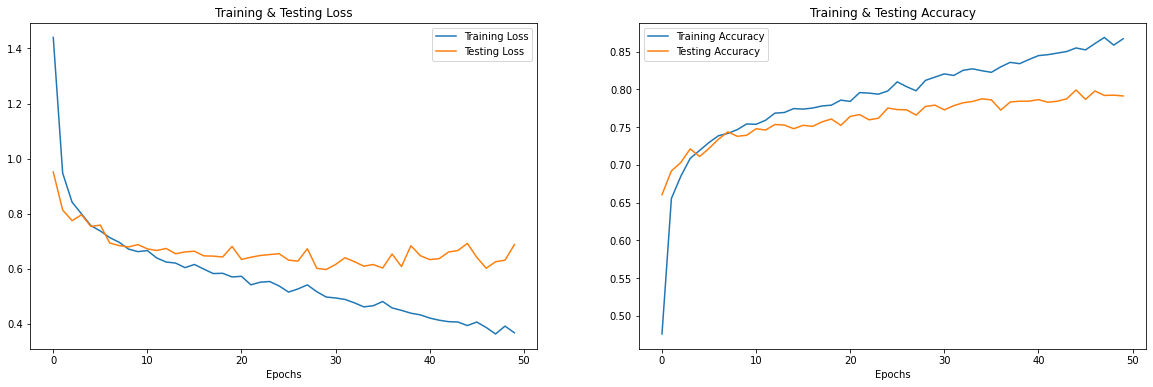

In [ ]:
print("Accuracy of our model on test data : " , Model.evaluate(x_test_scale, y_test_onehot)[1]*100 , "%")
# epochs = 50

epochs = [i for i in range(epoch)] # epoch!
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
lb = LabelEncoder()
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
lb.fit(emotion)

pred_test = Model.predict(x_test_scale)

# print(pred_test.shape)
# print(np.argmax(pred_test, axis = 1))
# print(np.argmax(pred_test, axis = 1).shape)

pred_test = np.argmax(pred_test, axis = 1)
y_pred = lb.inverse_transform(pred_test) ## number -> string (emotion)

# print(y_pred.shape) # (358,)
# print(y_test_mel2d.shape) # list. 358

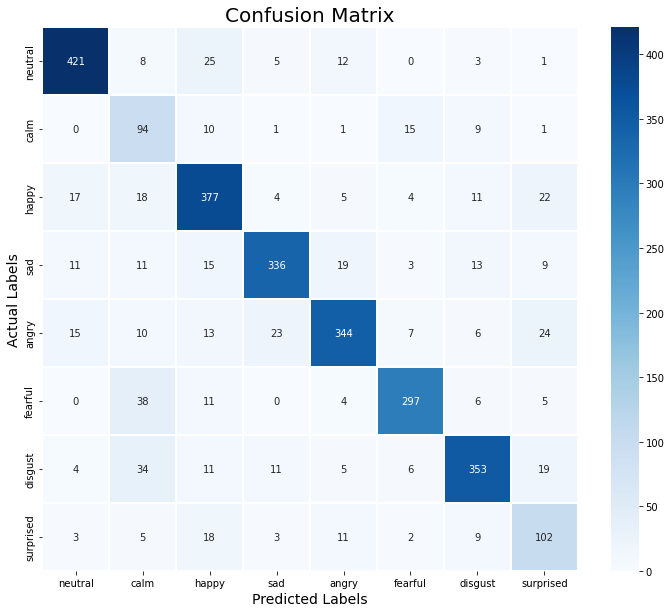

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.categories_] , columns = [i for i in lb.categories_])
cm = pd.DataFrame(cm , index = [i for i in emotion] , columns = [i for i in emotion])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Model B: Conv2d model
- Accuracy: 73.75%

## data preprocessing (feature extraction, train test split)

In [ ]:
def extract_mel2d(file, plot_mel = False): # mel 2d

  y, sr = librosa.load(file, sr = 48000)
  result=np.array([])

  mel = librosa.feature.melspectrogram(y=y, sr=48000, n_mels=128)
  # print("shape of mel: ", mel.shape)

  result = np.array(mel)
  result = np.expand_dims(result, axis=-1)
  # print("shape of result : ", result.shape)

  if plot_mel:
    fig, ax = plt.subplots()
    mel_dB = librosa.power_to_db(mel, ref=np.max)
    img = librosa.display.specshow(mel_dB, x_axis='time', y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    title = 'Mel Spectrogram'

    ax.set(title=title)
    # print("mel_dB: ", mel_dB) 
    # print("This is mel_dB.shape : ", mel_dB.shape) # (128, 300-400)
    plt.show()

  return result

In [ ]:
# mel 2d 
def load_data_mel2d(test_size = 0.2, plot_mel = False):

  x = np.array([])
  cnt = 0
  # x,y=[],[]
  y = []

  for file in glob.glob(path_tess2):
    
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

    except:
      print("decoding error")
      continue
    
    if 'ps' in file_name:
        continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    
    if 'aug' in file_name:
      emotion=emotions_tess[file_name.split("_")[2]]
    else:
      emotion=emotions_tess[file_name.split("_")[2][:-4]]
      
    features = extract_mel2d(file, plot_mel)
    # cnt += 1

    if x.size == 0:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = features
    else:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = np.vstack((x, features))

    print("This is x.shape: ", x.shape)
    # print(x)
    y.append(emotion)
    # print("append success") 

  for file in glob.glob(path_orig2):
    
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")


    except:
      print("decoding error")
      continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    emotion=emotions[file_name.split("-")[2]]
    features = extract_mel2d(file, plot_mel)
    # cnt += 1

    if x.size == 0:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = features
    else:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = np.vstack((x, features))

    print("This is x.shape: ", x.shape)
    # print(x)
    y.append(emotion)
    # print("append success")

    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y

  # return x, y
  return train_test_split(np.array(x), y, test_size=test_size, random_state=9, shuffle=True)

In [ ]:
x_train_mel2d, x_test_mel2d, y_train_mel2d, y_test_mel2d = load_data_mel2d(test_size = 0.25, plot_mel = False) 

In [ ]:
print(x_train_mel2d.shape) # should be (n, 128, 188)
print(x_test_mel2d.shape)
print(len(y_train_mel2d))
print(len(y_test_mel2d))

(8638, 128, 188, 1)
(2880, 128, 188, 1)
8638
2880


In [ ]:
## exporting mel2d data

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_train_mel2d.npy', 'wb') as f:
  np.save(f, x_train_mel2d)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_train_mel2d.npy', 'wb') as f:
  np.save(f, y_train_mel2d)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_test_mel2d.npy', 'wb') as f:
  np.save(f, x_test_mel2d)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_test_mel2d.npy', 'wb') as f:
  np.save(f, y_test_mel2d) 

In [15]:
with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_train_mel2d.npy', 'rb') as f:
  x_train_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_train_mel2d.npy', 'rb') as f:
  y_train_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_test_mel2d.npy', 'rb') as f:
  x_test_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_test_mel2d.npy', 'rb') as f:
  y_test_mel2d = np.load(f)

## conv2d model

In [16]:
# one hot encode the target 
lb = LabelEncoder()
y_train_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_train_mel2d))
y_test_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_test_mel2d))

In [ ]:
print(y_train_mel2d_onehot)
print(y_test_mel2d_onehot)
print(y_train_mel2d_onehot.shape)
print(y_test_mel2d_onehot.shape)

In [23]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tfl.Conv2D(8, (4, 4), strides = (1, 1), padding = 'SAME')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=8, padding = "SAME")(A1)
    D1 = Dropout(rate=0.2)(P1)
    
    Z2 = tfl.Conv2D(16, (2, 2), strides = (1, 1), padding = 'SAME')(D1) 
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D((4, 4), (4, 4), padding= 'SAME')(A2)
    D2 = Dropout(rate = 0.2)(P2)
    F = tfl.Flatten()(D2)
    outputs = tfl.Dense(8, activation = 'softmax')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [24]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [25]:
conv_model = convolutional_model((x_train_mel2d.shape[1], x_train_mel2d.shape[2], x_train_mel2d.shape[3]))
conv_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 188, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 188, 8)       136       
                                                                 
 re_lu (ReLU)                (None, 128, 188, 8)       0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 24, 8)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 24, 8)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 24, 16)        528       
                                                             

In [26]:
epoch = 50
history = conv_model.fit(x_train_mel2d, y_train_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 32, epochs=epoch)

Epoch 1/50
270/270 [==============================] - 12s 9ms/step - loss: 2.9172 - accuracy: 0.2890 - val_loss: 1.7479 - val_accuracy: 0.3972
Epoch 2/50
270/270 [==============================] - 2s 7ms/step - loss: 1.7423 - accuracy: 0.3795 - val_loss: 1.6533 - val_accuracy: 0.4563
Epoch 3/50
270/270 [==============================] - 2s 7ms/step - loss: 1.6255 - accuracy: 0.4190 - val_loss: 1.5865 - val_accuracy: 0.4684
Epoch 4/50
270/270 [==============================] - 2s 7ms/step - loss: 1.5351 - accuracy: 0.4619 - val_loss: 1.5123 - val_accuracy: 0.5080
Epoch 5/50
270/270 [==============================] - 2s 7ms/step - loss: 1.4974 - accuracy: 0.4826 - val_loss: 1.4316 - val_accuracy: 0.5160
Epoch 6/50
270/270 [==============================] - 2s 7ms/step - loss: 1.4269 - accuracy: 0.5091 - val_loss: 1.3616 - val_accuracy: 0.5517
Epoch 7/50
270/270 [==============================] - 2s 7ms/step - loss: 1.3868 - accuracy: 0.5366 - val_loss: 1.3223 - val_accuracy: 0.5757
Epoch

In [ ]:
temp = conv_model.evaluate(x_test_mel2d, y_test_mel2d_onehot)

### acc loss plot & heatmap

90/90 [==============================] - 0s 4ms/step - loss: 0.8169 - accuracy: 0.7309
Accuracy of our model on test data :  73.09027910232544 %


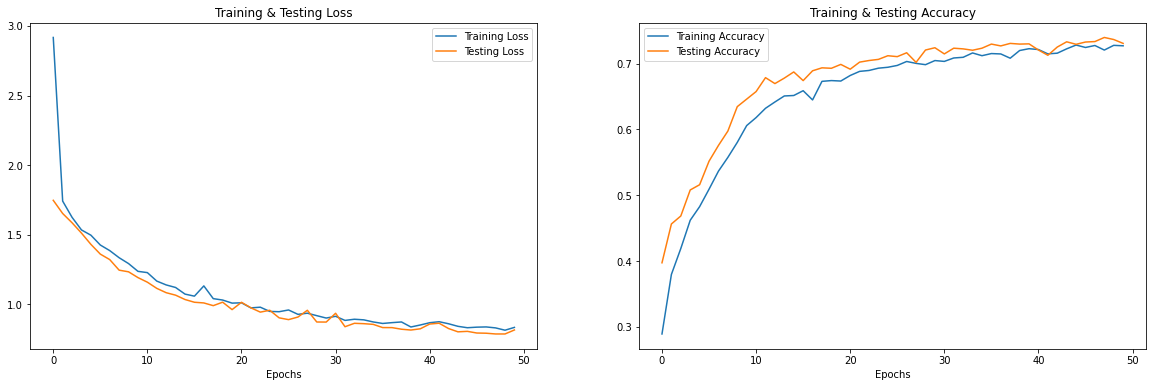

In [27]:
print("Accuracy of our model on test data : " , conv_model.evaluate(x_test_mel2d,y_test_mel2d_onehot)[1]*100 , "%")

epochs = [i for i in range(epoch)] # epoch!
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
lb = LabelEncoder()
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
lb.fit(emotion)

pred_test = conv_model.predict(x_test_mel2d)

# print(pred_test.shape)
# print(np.argmax(pred_test, axis = 1))
# print(np.argmax(pred_test, axis = 1).shape)

pred_test = np.argmax(pred_test, axis = 1)
y_pred = lb.inverse_transform(pred_test) ## number -> string (emotion)

# print(y_pred.shape) # (358,)
# print(y_test_mel2d.shape) # list. 358

In [ ]:
cm = confusion_matrix(y_test_mel2d, y_pred)
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.categories_] , columns = [i for i in lb.categories_])
cm = pd.DataFrame(cm , index = [i for i in emotion] , columns = [i for i in emotion])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Model C: Conv2d model (MAIN model)
- Accuracy: 85.14%

## data preprocessing (feature extraction, train test split)

In [ ]:
def extract_mel2d(file, plot_mel = False): # mel 2d

  y, sr = librosa.load(file, sr = 48000)
  result=np.array([])

  mel = librosa.feature.melspectrogram(y=y, sr=48000, n_mels=128)
  # print("shape of mel: ", mel.shape)

  result = np.array(mel)
  result = np.expand_dims(result, axis=-1)
  # print("shape of result : ", result.shape)

  if plot_mel:
    fig, ax = plt.subplots()
    mel_dB = librosa.power_to_db(mel, ref=np.max)
    img = librosa.display.specshow(mel_dB, x_axis='time', y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    title = 'Mel Spectrogram'

    ax.set(title=title)
    # print("mel_dB: ", mel_dB) 
    # print("This is mel_dB.shape : ", mel_dB.shape) # (128, 300-400)
    plt.show()

  return result

In [ ]:
# mel 2d 
def load_data_mel2d(test_size = 0.2, plot_mel = False):

  x = np.array([])
  cnt = 0
  # x,y=[],[]
  y = []

  for file in glob.glob(path_tess2):
    
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

    except:
      print("decoding error")
      continue
    
    if 'ps' in file_name:
        continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    
    if 'aug' in file_name:
      emotion=emotions_tess[file_name.split("_")[2]]
    else:
      emotion=emotions_tess[file_name.split("_")[2][:-4]]
      
    features = extract_mel2d(file, plot_mel)
    # cnt += 1

    if x.size == 0:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = features
    else:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = np.vstack((x, features))

    print("This is x.shape: ", x.shape)
    # print(x)
    y.append(emotion)
    # print("append success") 

  for file in glob.glob(path_orig2):
    
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")


    except:
      print("decoding error")
      continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    emotion=emotions[file_name.split("-")[2]]
    features = extract_mel2d(file, plot_mel)
    # cnt += 1

    if x.size == 0:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = features
    else:
      features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
      x = np.vstack((x, features))

    print("This is x.shape: ", x.shape)
    # print(x)
    y.append(emotion)
    # print("append success")

    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y

  # return x, y
  return train_test_split(np.array(x), y, test_size=test_size, random_state=9, shuffle=True)

In [ ]:
x_train_mel2d, x_test_mel2d, y_train_mel2d, y_test_mel2d = load_data_mel2d(test_size = 0.25, plot_mel = False) 

In [ ]:
print(x_train_mel2d.shape) # should be (n, 128, 188)
print(x_test_mel2d.shape)
print(len(y_train_mel2d))
print(len(y_test_mel2d))

(8638, 128, 188, 1)
(2880, 128, 188, 1)
8638
2880


In [ ]:
## exporting mel2d data

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_train_mel2d.npy', 'wb') as f:
  np.save(f, x_train_mel2d)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_train_mel2d.npy', 'wb') as f:
  np.save(f, y_train_mel2d)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_test_mel2d.npy', 'wb') as f:
  np.save(f, x_test_mel2d)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_test_mel2d.npy', 'wb') as f:
  np.save(f, y_test_mel2d) 

In [ ]:
with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_train_mel2d.npy', 'rb') as f:
  x_train_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_train_mel2d.npy', 'rb') as f:
  y_train_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/x_test_mel2d.npy', 'rb') as f:
  x_test_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/mel_aug_numpy/y_test_mel2d.npy', 'rb') as f:
  y_test_mel2d = np.load(f)

## conv2d model

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_train_mel2d))
y_test_mel2d_onehot = np_utils.to_categorical(lb.fit_transform(y_test_mel2d))

In [ ]:
print(y_train_mel2d_onehot)
print(y_test_mel2d_onehot)
print(y_train_mel2d_onehot.shape)
print(y_test_mel2d_onehot.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]
(8638, 8)
(2880, 8)


In [ ]:
def convolutional_model(input_shape):
    input_img = tf.keras.Input(shape=input_shape)
    Z1 = tfl.Conv2D(32, (4, 4), strides = (1, 1), padding = 'SAME')(input_img)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=8, padding = "SAME")(A1)
    D1 = Dropout(rate=0.2)(P1)
    
    Z2 = tfl.Conv2D(64, (2, 2), strides = (1, 1), padding = 'SAME')(D1) 
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D((4, 4), (4, 4), padding= 'SAME')(A2)
    D2 = Dropout(rate = 0.2)(P2)
    F = tfl.Flatten()(D2)
    outputs = tfl.Dense(8, activation = 'softmax')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
conv_model = convolutional_model((x_train_mel2d.shape[1], x_train_mel2d.shape[2], x_train_mel2d.shape[3]))
conv_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 188, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 188, 32)      544       
                                                                 
 re_lu (ReLU)                (None, 128, 188, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 24, 64)        8256      
                                                             

In [ ]:
epoch = 200
history = conv_model.fit(x_train_mel2d, y_train_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 32, epochs=epoch)

In [ ]:
temp = conv_model.evaluate(x_test_mel2d, y_test_mel2d_onehot)

90/90 [==============================] - 0s 5ms/step - loss: 0.6285 - accuracy: 0.8691


### acc loss plot & heatmap

90/90 [==============================] - 0s 5ms/step - loss: 0.6058 - accuracy: 0.8514
Accuracy of our model on test data :  85.13888716697693 %


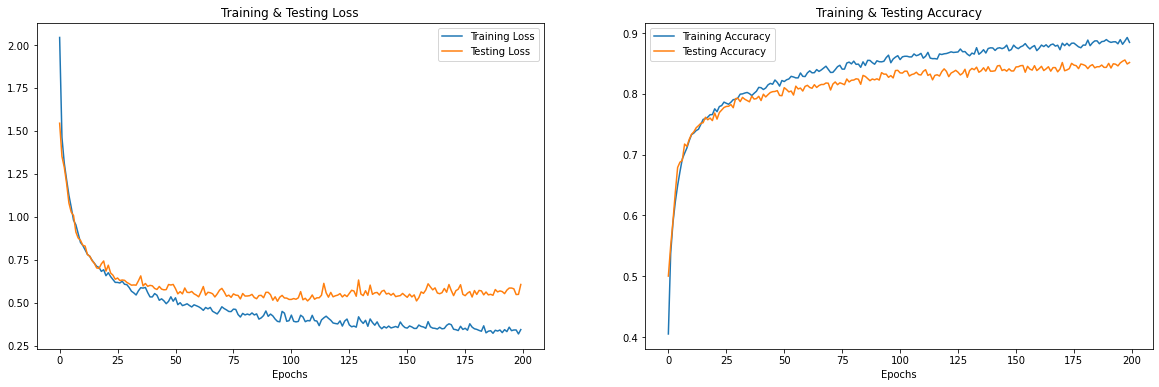

In [ ]:
print("Accuracy of our model on test data : " , conv_model.evaluate(x_test_mel2d,y_test_mel2d_onehot)[1]*100 , "%")

epochs = [i for i in range(epoch)] # epoch!
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
lb = LabelEncoder()
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
lb.fit(emotion)

pred_test = conv_model.predict(x_test_mel2d)

# print(pred_test.shape)
# print(np.argmax(pred_test, axis = 1))
# print(np.argmax(pred_test, axis = 1).shape)

pred_test = np.argmax(pred_test, axis = 1)
y_pred = lb.inverse_transform(pred_test) ## number -> string (emotion)

# print(y_pred.shape) # (358,)
# print(y_test_mel2d.shape) # list. 358

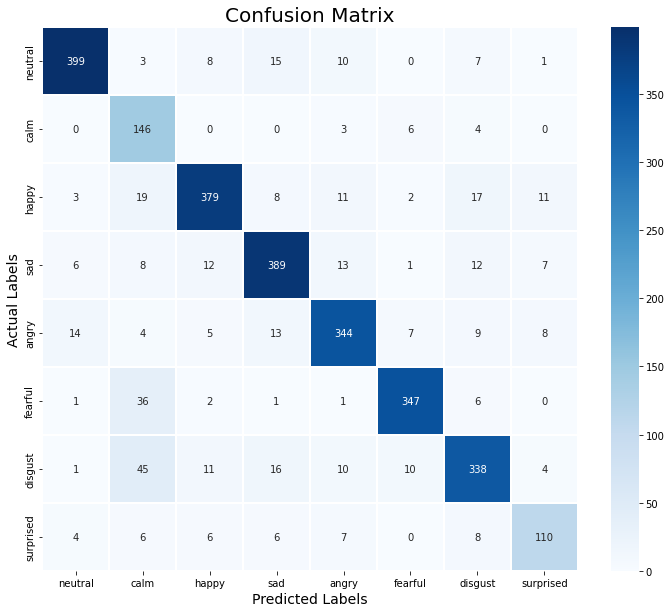

In [ ]:
cm = confusion_matrix(y_test_mel2d, y_pred)
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.categories_] , columns = [i for i in lb.categories_])
cm = pd.DataFrame(cm , index = [i for i in emotion] , columns = [i for i in emotion])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [ ]:
print(classification_report(y_test_mel2d, y_pred, target_names=emotions.values()))

              precision    recall  f1-score   support

     neutral       0.93      0.90      0.92       443
        calm       0.55      0.92      0.69       159
       happy       0.90      0.84      0.87       450
         sad       0.87      0.87      0.87       448
       angry       0.86      0.85      0.86       404
     fearful       0.93      0.88      0.90       394
     disgust       0.84      0.78      0.81       435
   surprised       0.78      0.75      0.76       147

    accuracy                           0.85      2880
   macro avg       0.83      0.85      0.83      2880
weighted avg       0.86      0.85      0.85      2880



# Other experiments

## mel plot, waveplot

In [ ]:
## waveplot
for file in glob.glob(path_tess2):

  file_name=os.path.basename(file)
  SAMPLE_RATE = 48000
  # fname_m = 'recordings/' + 'english381.mp3' 
  y, sr = librosa.load(file, sr=SAMPLE_RATE)

  plt.figure(figsize=(12, 3))
  plt.figure()
  librosa.display.waveplot(y, sr=sr)

  if 'ps' in file_name:
    continue

  if 'aug' in file_name:
    emotion=emotions_tess[file_name.split("_")[2]]
    title = 'Audio sample for \''+emotion+ '\' from augmentation'
  else:
    emotion=emotions_tess[file_name.split("_")[2][:-4]]
    title = 'Audio sample for \''+emotion+ '\' from original'

  plt.title(title)
  plt.show()

## extract features

In [ ]:
def extract_mel2d(file, plot_mel = False): # mel 2d

  y, sr = librosa.load(file, sr = 48000)
  result=np.array([])

  mel = librosa.feature.melspectrogram(y=y, sr=48000, n_mels=128)
  # print("shape of mel: ", mel.shape)

  result = np.array(mel)
  result = np.expand_dims(result, axis=-1)
  # print("shape of result : ", result.shape)

  if plot_mel:
    fig, ax = plt.subplots()
    mel_dB = librosa.power_to_db(mel, ref=np.max)
    img = librosa.display.specshow(mel_dB, x_axis='time', y_axis='mel', sr=sr, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    title = 'Mel Spectrogram'
    ax.set(title=title)
    plt.show()

  return result

In [ ]:
def extract_feature_all(file_name, mfcc, chroma, mel): # mel 1d (mean), mel&mfcc 1d

  with soundfile.SoundFile(file_name) as sound_file:
      X = sound_file.read(dtype="float32")
      sample_rate=sound_file.samplerate
      result=np.array([])
      if chroma:
          stft=np.abs(librosa.stft(X))
      if mfcc:
          mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
          result=np.hstack((result, mfccs))
      if chroma:
          chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
          result=np.hstack((result, chroma))
      if mel:
          mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
          result=np.hstack((result, mel))
  print("This is feature shape : ", result.shape)
  return result

In [ ]:
def extract_feature(file_name, feature, plot_mel): # 1d mfcc, 1d mel (flatten)
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    result=np.array([])

    if feature == 'mfcc':
      mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0) # mean...
      # temp = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc = 40)
      # librosa.display.specshow(temp)
      # plt.colorbar()
      # plt.show()
      # print("this is shape of temp: ", temp.shape) # (40, 200-300)
      # print("This is shape of mfccs: ", mfccs.shape) # (40, )
      result=np.hstack((result, mfccs))
    elif feature == 'mel':
      # mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0) # mean??
      mel = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128)
      # print("shape of mel: ", mel.shape)
      mel = mel.flatten()
      # print("shape of mel.flatten(): ", mel.shape) # (12---, )
      result=np.hstack((result, mel))
      # result = mel

      if plot_mel:
        # D = librosa.stft(X)  # STFT of X
        # S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

        # fig, ax = plt.subplots()
        # img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
        # ax.set(title='Mel Spectrogram')
        # fig.colorbar(img, ax=ax, format="%+2.f dB")
        # plt.show()
        fig, ax = plt.subplots()
        mel_dB = librosa.power_to_db(mel, ref=np.max)
        img = librosa.display.specshow(mel_dB, x_axis='time', y_axis='mel', sr=sample_rate, ax=ax)
        fig.colorbar(img, ax=ax, format='%+2.0f dB')
        ax.set(title='Mel-frequency spectrogram')
        print("mel_dB: ", mel_dB) 
        print("This is mel_dB.shape : ", mel_dB.shape) # (128, 300-400)


    return result

In [ ]:
def extract_mfcc2d(file_name): # mfcc 2d
  with soundfile.SoundFile(file_name) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    # SAMPLE_RATE = 22050
    result=np.array([])

    mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc = 40)
    print("shape of mfcc: ", mfcc.shape) # (40, 282)
    # result=np.hstack((result, mel))
    result = np.array(mfcc)
    result = np.expand_dims(mfcc, axis=-1)
    print("shape of result : ", result.shape)
  
  return result

## load data

In [ ]:
# MAIN mel 2d 
def load_data_mel2d(test_size = 0.2, plot_mel = False):
  # x = np.empty(shape = (128, 469, 1))
  x = np.array([])
  cnt = 0
  # x,y=[],[]
  y = []
  for file in glob.glob(path_new):
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue

      emotion=emotions[file_name.split("-")[2]]
      features = extract_mel2d(file, plot_mel)
      # cnt += 1

      if x.size == 0:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = features
      else:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = np.vstack((x, features))

      # print("This is x.shape: ", x.shape)
      # print(x)
      y.append(emotion)
      # print("append success")
      
    except: # decoding error..
      print("decoding error")
      print(file)
      print(sound.duration_seconds)
      continue
    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y

  # return x, y
  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [ ]:
# all features 1d (mean)
def load_data(test_size=0.2): # mel 1d (mean)
  x,y=[],[]
  for file in glob.glob(path_tess2):
    
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")
      if 'ps' in file_name:
        continue

    except:
      print("decoding error")
      continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    if 'aug' in file_name:
      emotion=emotions_tess[file_name.split("_")[2]]
    else:
      emotion=emotions_tess[file_name.split("_")[2][:-4]]

    feature=extract_feature_all(file, mfcc=True, chroma=False, mel=True)
    x.append(feature)
    y.append(emotion) 

  for file in glob.glob(path_orig2):
    try:
      # print(file)
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")
    except:
      print("decoding error")
      continue

    if sound.duration_seconds !=2.0:
      print("duration error!")
      continue

    emotion=emotions[file_name.split("-")[2]]
    # if emotion not in observed_emotions:
    #     continue
    feature=extract_feature_all(file, mfcc=True, chroma=False, mel=True)
    x.append(feature)
    y.append(emotion)


  
    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y


  return train_test_split(np.array(x), y, test_size=test_size, random_state=9, shuffle = True)

In [ ]:
# mfcc 1d (mean)
def load_data_mfcc1d(test_size = 0.2, feature = 'mfcc', plot_mel = False):
  x,y=[],[]
  for file in glob.glob(path_orig2):
    try:
      # print(file)
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

    except: # decoding error..
      print("decoding error")
      continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    emotion=emotions[file_name.split("-")[2]]
    features = extract_feature(file, feature = feature, plot_mel = plot_mel)
    # feature = extract_feature_all(file, mfcc= True, chroma = False, mel = True)
    x.append(features)
    y.append(emotion)

  for file in glob.glob(path_tess2):
    try:
      # print(file)
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

    except: # decoding error..
      print("decoding error")
      continue

    if sound.duration_seconds != 2.0:
      print("duration error!")
      continue

    emotion=emotions_tess[file_name.split("_")[2][:-4]]
    features = extract_feature(file, feature = feature, plot_mel = plot_mel)
    # feature = extract_feature_all(file, mfcc= True, chroma = False, mel = True)
    x.append(features)
    y.append(emotion)

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9, shuffle = True)

In [ ]:
# mel 1d (flatten) 
def load_data_mel1d(test_size = 0.2, feature = 'mel', plot_mel = False):
  x,y=[],[]
  cnt = 1
  for file in glob.glob(path):
    try:
      file_name=os.path.basename(file)
      # y, sr = librosa.load(file_name, offset=1.0, duration=3.0)
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue
      
      # print("{}th duration: {}".format(cnt, sound.duration_seconds))
      emotion=emotions[file_name.split("-")[2]]
      features = extract_feature(file, feature = feature, plot_mel = plot_mel) # file
      # feature = extract_feature_all(file, mfcc= True, chroma = False, mel = True)
      x.append(features)
      y.append(emotion)
      cnt += 1
    
    except:
      print("=============Error============")
      continue
    

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [ ]:
# mfcc 2d 
def load_data_mfcc2d(test_size = 0.2):
  # x = np.empty(shape = (128, 469, 1))
  x = np.array([])
  cnt = 0
  y = []
  for file in glob.glob(path):
    try:
      file_name=os.path.basename(file)
      #converting stereo audio to mono
      sound = AudioSegment.from_wav(file)
      sound = sound.set_channels(1)
      sound.export(file, format="wav")

      if sound.duration_seconds != 3.0:
        print("duration error!")
        continue

      emotion=emotions[file_name.split("-")[2]]
      features = extract_mfcc2d(file)

      if x.size == 0:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = features
      else:
        features = features.reshape(1, features.shape[0], features.shape[1], features.shape[2])
        x = np.vstack((x, features))

      print("This is x.shape: ", x.shape)
      y.append(emotion)
      
    except:
      print("decoding error")
      continue
    
  try:
    temp = np.array(x)  
    print("This is final np.array(x).shape: ", temp.shape)
  except:
    print("fail to np.array(x).shape")
    return x, y, x, y

  return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

## train test load

In [ ]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25) # 7min 25sec

In [ ]:
with open('gdrive/MyDrive/melmfcc_numpy/x_train.npy', 'wb') as f:
  np.save(f, x_train)

with open('gdrive/MyDrive/melmfcc_numpy/y_train.npy', 'wb') as f:
  np.save(f, y_train)

with open('gdrive/MyDrive/melmfcc_numpy/x_test.npy', 'wb') as f:
  np.save(f, x_test)

with open('gdrive/MyDrive/melmfcc_numpy/y_test.npy', 'wb') as f:
  np.save(f, y_test) 

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(len(y_train))
print(len(y_test))

(8638, 168)
(2880, 168)
8638
2880


1. mfcc + melSpectrogram 1d (mean)
- x_train.shape : (1072, 168) 
- x_test.shape: (358, 168)
- y_train.shape : list. len 1072
- y_test.shape: : list. len 358

In [ ]:
x_train_mfcc1d, x_test_mfcc1d, y_train_mfcc1d, y_test_mfcc1d = load_data_mfcc1d(test_size=0.25, feature = 'mfcc', plot_mel = False) # 25sec

decoding error


In [ ]:
print(x_train_mfcc1d.shape)
print(x_test_mfcc1d.shape)
print(len(y_train_mfcc1d))
print(len(y_test_mfcc1d))

(2877, 40)
(960, 40)
2877
960


2. Baseline: mfcc 1d (1 data decoding error)
- x_train_mfcc1d.shape : (1074, 40) 
- x_test_mfcc1d.shape : (359, 40)
- y_train_mfcc1d: list. len 1074
- y_test_mfcc1d: list. len 359  

In [ ]:
print(f'Features extracted (mfcc): {x_train_mfcc1d.shape[1]}')

In [ ]:
x_train_mel2d, x_test_mel2d, y_train_mel2d, y_test_mel2d = load_data_mel2d(test_size = 0.25, plot_mel = False) # 9min

In [ ]:
with open('gdrive/MyDrive/mel_numpy/x_train_mel2d.npy', 'wb') as f:
  np.save(f, x_train_mel2d)

with open('gdrive/MyDrive/mel_numpy/y_train_mel2d.npy', 'wb') as f:
  np.save(f, y_train_mel2d)

with open('gdrive/MyDrive/mel_numpy/x_test_mel2d.npy', 'wb') as f:
  np.save(f, x_test_mel2d)

with open('gdrive/MyDrive/mel_numpy/y_test_mel2d.npy', 'wb') as f:
  np.save(f, y_test_mel2d)  

In [ ]:
with open('gdrive/MyDrive/mel_numpy/x_train_mel2d.npy', 'rb') as f:
  x_train_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/y_train_mel2d.npy', 'rb') as f:
  y_train_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/x_test_mel2d.npy', 'rb') as f:
  x_test_mel2d = np.load(f)

with open('gdrive/MyDrive/mel_numpy/y_test_mel2d.npy', 'rb') as f:
  y_test_mel2d = np.load(f) 

In [ ]:
print(x_train_mel2d.shape)
print(x_test_mel2d.shape)
print(len(y_train_mel2d))
print(len(y_test_mel2d))

(5416, 128, 282, 1)
(1806, 128, 282, 1)
5416
1806


3. MAIN: mel spectogram 2d (after augmentation)
- x_train_mel2d.shape: (5416, 128, 282, 1)
- x_test_mel2d.shape: (1806, 128, 282, 1)
- y_train_mel2d: list. len 5416
- y_test_mel2d: list. len 1806

In [ ]:
x_train_mel1d, x_test_mel1d, y_train_mel1d, y_test_mel1d = load_data_mel1d(test_size=0.25, feature = 'mel', plot_mel = False) # 6 min

In [ ]:
print(x_train_mel1d.shape)
print(x_test_mel1d.shape)
print(len(y_train_mel1d))
print(len(y_test_mel1d))

4. mel spectogram 1d (flatten)
- x_train_mel1d.shape: (1072, 36096)
- x_test_mel1d.shape: (358, 36096)
- y_train_mel1d: list. len 1072
- y_test_mel1d: list. len 358

In [ ]:
x_train_mel1d_mean, x_test_mel1d_mean, y_train_mel1d_mean, y_test_mel1d_mean = load_data(test_size=0.25)

In [ ]:
print(x_train_mel1d_mean.shape)
print(x_test_mel1d_mean.shape)
print(len(y_train_mel1d_mean))
print(len(y_test_mel1d_mean))

(1071, 128)
(358, 128)
1071
358


5. mel 1d (mean)
- x_train_mel1d_mean.shape: (1072, 128)
- x_test_mel1d_mean.shape: (358, 128)
- y_train_mel1d_mean.shape: (1072, 128)
- y_test_mel1d_mean.shape: (358, 128)


In [ ]:
x_train_mfcc2d, x_test_mfcc2d, y_train_mfcc2d, y_test_mfcc2d = load_data_mfcc2d(test_size=0.25)

In [ ]:
print(x_train_mfcc2d.shape)
print(x_test_mfcc2d.shape)
print(len(y_train_mfcc2d))
print(len(y_test_mfcc2d))

(1072, 40, 282, 1)
(358, 40, 282, 1)
1072
358


6. mfcc 2d
- x_train_mfcc2d.shape: (1072, 40, 282, 1)
- x_test_mfcc2d.shape: (358, 40, 282, 1)
- y_train_mfcc2d: list. len 1072
- y_test_mfcc2d: list. len 358

## model


## 2d CNN (with batch normalization)
- accuracy: 51.4% (overfitting)

In [ ]:
def convolutional_model(input_shape): # add batch normalization
    input_img = tf.keras.Input(shape=input_shape)
    ## CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(8, (4, 4), strides = (1, 1), padding = 'SAME')(input_img)
    ## RELU
    B1 = tfl.BatchNormalization()(Z1)
    A1 = tfl.ReLU()(B1)
    ## MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPool2D(pool_size=(8, 8), strides=8, padding = "SAME")(A1)# maxpooling 에서서 padding이이 same인인 건건 뭐지지?
    ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(16, (2, 2), strides = (1, 1), padding = 'SAME')(P1) 
    ## RELU
    B2 = tfl.BatchNormalization()(Z2)
    A2 = tfl.ReLU()(B2)
    ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPool2D((4, 4), (4, 4), padding= 'SAME')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 8 neurons in output layer. 
    outputs = tfl.Dense(8, activation = 'softmax')(F)
    
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    return model

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)

In [ ]:
conv_model = convolutional_model((x_train_mel2d.shape[1], x_train_mel2d.shape[2], x_train_mel2d.shape[3])) # input shape(2, 3, 4)
conv_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 128, 282, 1)]     0         
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 282, 8)       136       
                                                                 
 batch_normalization_11 (Bat  (None, 128, 282, 8)      32        
 chNormalization)                                                
                                                                 
 re_lu_19 (ReLU)             (None, 128, 282, 8)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 36, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 16, 36, 16)        528 

In [ ]:
history = conv_model.fit(x_test_mel2d, y_test_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 8, epochs=50)

Epoch 1/50
45/45 [==============================] - 1s 11ms/step - loss: 2.7385 - accuracy: 0.1453 - val_loss: 2.3989 - val_accuracy: 0.2067
Epoch 2/50
45/45 [==============================] - 0s 7ms/step - loss: 2.2109 - accuracy: 0.2263 - val_loss: 1.9667 - val_accuracy: 0.2318
Epoch 3/50
45/45 [==============================] - 0s 7ms/step - loss: 2.0624 - accuracy: 0.2626 - val_loss: 1.8624 - val_accuracy: 0.2654
Epoch 4/50
45/45 [==============================] - 0s 7ms/step - loss: 1.8847 - accuracy: 0.2793 - val_loss: 1.8402 - val_accuracy: 0.2933
Epoch 5/50
45/45 [==============================] - 0s 7ms/step - loss: 1.8674 - accuracy: 0.2961 - val_loss: 1.8430 - val_accuracy: 0.2709
Epoch 6/50
45/45 [==============================] - 0s 7ms/step - loss: 1.7888 - accuracy: 0.3268 - val_loss: 1.8202 - val_accuracy: 0.2654
Epoch 7/50
45/45 [==============================] - 0s 7ms/step - loss: 1.7138 - accuracy: 0.3380 - val_loss: 1.7991 - val_accuracy: 0.2989
Epoch 8/50
45/45 [=

In [ ]:
temp = conv_model.evaluate(x_test_mel2d, y_test_mel2d_onehot) # overfitting when with batch norm..
# epoch 50
# 41.9 (batch 1)
# 45.8 (batch 8)
# 51.4 (batch 4) (**)
# 43.0 (batch 16)

# w/o batch normalization: 75%

12/12 [==============================] - 0s 5ms/step - loss: 1.5143 - accuracy: 0.4581


### loss & acc plot (overfitting)

12/12 [==============================] - 0s 5ms/step - loss: 1.5792 - accuracy: 0.4246
Accuracy of our model on test data :  42.458099126815796 %


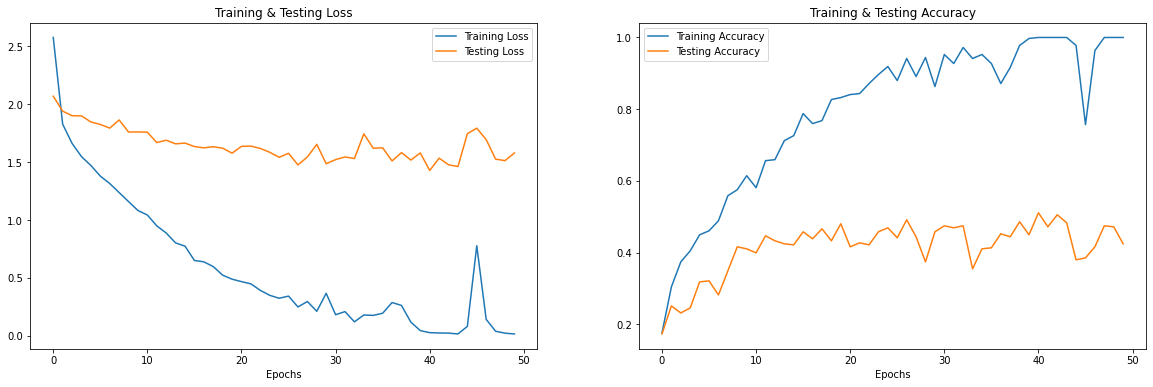

In [ ]:
print("Accuracy of our model on test data : " , conv_model.evaluate(x_test_mel2d,y_test_mel2d_onehot)[1]*100 , "%")

epochs = [i for i in range(50)] # epoch!
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## 2d CNN (sparse cross entropy)

In [ ]:
loss='sparse_categorical_crossentropy'

In [ ]:
conv_model = convolutional_model((x_train_mel2d.shape[1], x_train_mel2d.shape[2], x_train_mel2d.shape[3])) 
conv_model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 128, 282, 1)]     0         
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 282, 8)       136       
                                                                 
 re_lu_18 (ReLU)             (None, 128, 282, 8)       0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 16, 36, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 16, 36, 16)        528       
                                                                 
 re_lu_19 (ReLU)             (None, 16, 36, 16)        0         
                                                           

In [ ]:
history = conv_model.fit(x_test_mel2d, y_test_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 1, epochs=50)
temp = conv_model.evaluate(x_test_mel2d, y_test_mel2d)

## 2d CNN (adding layers. deeper)

In [ ]:
def convolutional_model(input_shape):
  input_img = tf.keras.Input(shape=input_shape)
  Z1 = tfl.Conv2D(8, (4, 4), strides = (1, 1), padding = 'SAME')(input_img)
  A1 = tfl.ReLU()(Z1)
  P1 = tfl.MaxPool2D(pool_size=(2, 2), strides=2, padding = "SAME")(A1)# (2, 4)?? 원래래 비율율..
  D1 = Dropout(rate=0.2)(P1)

  ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
  Z2 = tfl.Conv2D(16, (2, 2), strides = (1, 1), padding = 'SAME')(D1) 
  A2 = tfl.ReLU()(Z2)
  ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tfl.MaxPool2D((4, 4), (4, 4), padding= 'SAME')(A2)
  D2 = Dropout(rate=0.2)(P2)

  ## FLATTEN
  F1 = tfl.Flatten()(D2)
  F2 = tfl.Dense(256, activation='relu')(F1) # 1024?
  # F3 = tfl.Dense(256, activation='relu')(F2)
  ## Dense layer
  ## 8 neurons in output layer. 
  outputs = tfl.Dense(8, activation = 'softmax')(F2)

  model = tf.keras.Model(inputs=input_img, outputs=outputs)
  return model

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
# optimizer = tf.keras.optimizers.RMSprop()
conv_model = convolutional_model((x_train_mel2d.shape[1], x_train_mel2d.shape[2], x_train_mel2d.shape[3]))
conv_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 128, 282, 1)]     0         
                                                                 
 conv2d_46 (Conv2D)          (None, 128, 282, 8)       136       
                                                                 
 re_lu_22 (ReLU)             (None, 128, 282, 8)       0         
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 64, 141, 8)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 64, 141, 8)        0         
                                                                 
 conv2d_47 (Conv2D)          (None, 64, 141, 16)       528       
                                                          

In [ ]:
history = conv_model.fit(x_train_mel2d, y_train_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 8, epochs=20, shuffle=True)

Epoch 1/20
170/170 [==============================] - 3s 13ms/step - loss: 2.3159 - accuracy: 0.2668 - val_loss: 1.8268 - val_accuracy: 0.2996
Epoch 2/20
170/170 [==============================] - 2s 11ms/step - loss: 1.7295 - accuracy: 0.3364 - val_loss: 1.7675 - val_accuracy: 0.3178
Epoch 3/20
170/170 [==============================] - 2s 11ms/step - loss: 1.6470 - accuracy: 0.3713 - val_loss: 1.8083 - val_accuracy: 0.3162
Epoch 4/20
170/170 [==============================] - 2s 11ms/step - loss: 1.5935 - accuracy: 0.4073 - val_loss: 1.8080 - val_accuracy: 0.3522
Epoch 5/20
170/170 [==============================] - 2s 11ms/step - loss: 1.5515 - accuracy: 0.4212 - val_loss: 1.8026 - val_accuracy: 0.3594
Epoch 6/20
170/170 [==============================] - 2s 11ms/step - loss: 1.4682 - accuracy: 0.4655 - val_loss: 1.8243 - val_accuracy: 0.3588
Epoch 7/20
170/170 [==============================] - 2s 11ms/step - loss: 1.4240 - accuracy: 0.4782 - val_loss: 1.9273 - val_accuracy: 0.3726

In [ ]:
temp = conv_model.evaluate(x_test_mel2d, y_test_mel2d_onehot)

11/11 [==============================] - 0s 6ms/step - loss: 8.8422 - accuracy: 0.5015


11/11 [==============================] - 0s 6ms/step - loss: 8.8422 - accuracy: 0.5015
Accuracy of our model on test data :  50.14577507972717 %


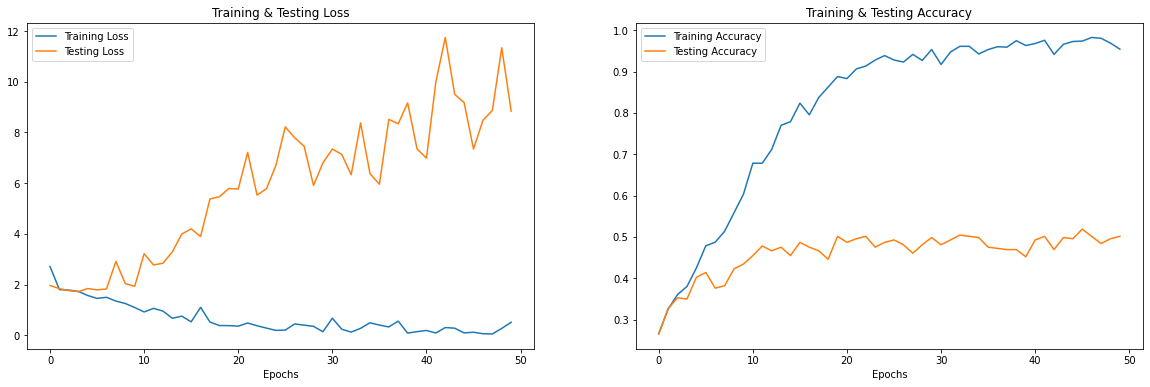

In [ ]:
print("Accuracy of our model on test data : " , conv_model.evaluate(x_test_mel2d,y_test_mel2d_onehot)[1]*100 , "%")

epochs = [i for i in range(50)] # epoch!
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
lb = LabelEncoder()
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
lb.fit(emotion)

pred_test = conv_model.predict(x_test_mel2d)

# print(pred_test.shape)
# print(np.argmax(pred_test, axis = 1))
# print(np.argmax(pred_test, axis = 1).shape)

pred_test = np.argmax(pred_test, axis = 1)
y_pred = lb.inverse_transform(pred_test) ## number -> string (emotion)

# print(y_pred.shape) # (358,)
# print(y_test_mel2d.shape) # list. 358

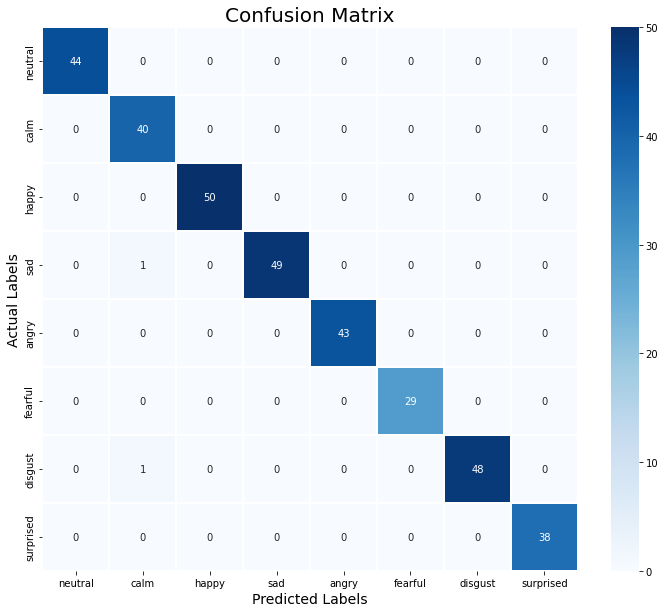

In [ ]:
cm = confusion_matrix(y_test_mel2d, y_pred)
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.categories_] , columns = [i for i in lb.categories_])
cm = pd.DataFrame(cm , index = [i for i in emotion] , columns = [i for i in emotion])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## 2d CNN (changing filter size, changing FC)

In [ ]:
def convolutional_model(input_shape):
  input_img = tf.keras.Input(shape=input_shape)
  Z1 = tfl.Conv2D(8, (4, 4), strides = (1, 1), padding = 'SAME')(input_img)
  A1 = tfl.ReLU()(Z1)
  P1 = tfl.MaxPool2D(pool_size=(2, 4), strides=(2, 4), padding = "SAME")(A1)# (2, 4)?? 원래래 비율율..

  ## CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
  Z2 = tfl.Conv2D(16, (2, 2), strides = (1, 1), padding = 'SAME')(P1) 
  A2 = tfl.ReLU()(Z2)
  ## MAXPOOL: window 4x4, stride 4, padding 'SAME'
  P2 = tfl.MaxPool2D((2, 4), (2, 4), padding= 'SAME')(A2)
  ## FLATTEN
  F1 = tfl.Flatten()(P2)
  F2 = tfl.Dense(120, activation='relu')(F1) # 1024?
  # F3 = tfl.Dense(256, activation='relu')(F2)
  ## Dense layer
  ## 8 neurons in output layer. 
  outputs = tfl.Dense(8, activation = 'softmax')(F2)

  model = tf.keras.Model(inputs=input_img, outputs=outputs)
  return model

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001)
# optimizer = tf.keras.optimizers.RMSprop()
conv_model = convolutional_model((x_train_mel2d.shape[1], x_train_mel2d.shape[2], x_train_mel2d.shape[3]))
conv_model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 128, 188, 1)]     0         
                                                                 
 conv2d_58 (Conv2D)          (None, 128, 188, 8)       136       
                                                                 
 re_lu_34 (ReLU)             (None, 128, 188, 8)       0         
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 64, 47, 8)        0         
 g2D)                                                            
                                                                 
 conv2d_59 (Conv2D)          (None, 64, 47, 16)        528       
                                                                 
 re_lu_35 (ReLU)             (None, 64, 47, 16)        0         
                                                          

In [ ]:
# Normalization as per the standard NN process
mean = np.mean(x_train_mel2d, axis=0)
std = np.std(x_train_mel2d, axis=0)

x_train_mel2d_norm = (x_train_mel2d - mean)/std
x_test_mel2d_norm = (x_test_mel2d - mean)/std

In [ ]:
history = conv_model.fit(x_train_mel2d, y_train_mel2d_onehot, validation_data=(x_test_mel2d, y_test_mel2d_onehot), batch_size = 32, epochs=20, shuffle = True)

Epoch 1/20
90/90 [==============================] - 1s 9ms/step - loss: 1.3834 - accuracy: 0.6279 - val_loss: 1.0799 - val_accuracy: 0.6979
Epoch 2/20
90/90 [==============================] - 1s 7ms/step - loss: 0.7806 - accuracy: 0.7578 - val_loss: 1.1094 - val_accuracy: 0.7333
Epoch 3/20
90/90 [==============================] - 1s 7ms/step - loss: 0.5757 - accuracy: 0.8019 - val_loss: 1.0873 - val_accuracy: 0.7427
Epoch 4/20
90/90 [==============================] - 1s 7ms/step - loss: 0.5031 - accuracy: 0.8238 - val_loss: 1.1128 - val_accuracy: 0.7490
Epoch 5/20
90/90 [==============================] - 1s 7ms/step - loss: 0.4698 - accuracy: 0.8436 - val_loss: 1.2309 - val_accuracy: 0.7531
Epoch 6/20
90/90 [==============================] - 1s 7ms/step - loss: 0.5402 - accuracy: 0.8419 - val_loss: 1.3591 - val_accuracy: 0.7469
Epoch 7/20
90/90 [==============================] - 1s 7ms/step - loss: 0.4789 - accuracy: 0.8464 - val_loss: 1.4247 - val_accuracy: 0.7292
Epoch 8/20
90/90 [==

In [ ]:
temp = conv_model.evaluate(x_test_mel2d, y_test_mel2d_onehot)

30/30 [==============================] - 0s 3ms/step - loss: 2.9977 - accuracy: 0.7823


30/30 [==============================] - 0s 4ms/step - loss: 2.9977 - accuracy: 0.7823
Accuracy of our model on test data :  78.22916507720947 %


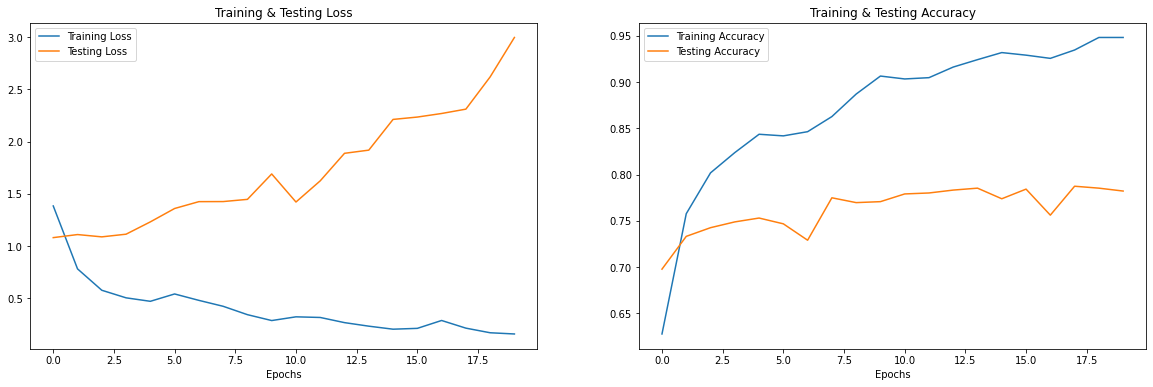

In [ ]:
print("Accuracy of our model on test data : " , conv_model.evaluate(x_test_mel2d,y_test_mel2d_onehot)[1]*100 , "%")

epochs = [i for i in range(20)] # epoch!
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
lb = LabelEncoder()
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
lb.fit(emotion)

pred_test = conv_model.predict(x_test_mel2d)

# print(pred_test.shape)
# print(np.argmax(pred_test, axis = 1))
# print(np.argmax(pred_test, axis = 1).shape)

pred_test = np.argmax(pred_test, axis = 1)
y_pred = lb.inverse_transform(pred_test) ## number -> string (emotion)

# print(y_pred.shape) # (358,)
# print(y_test_mel2d.shape) # list. 358

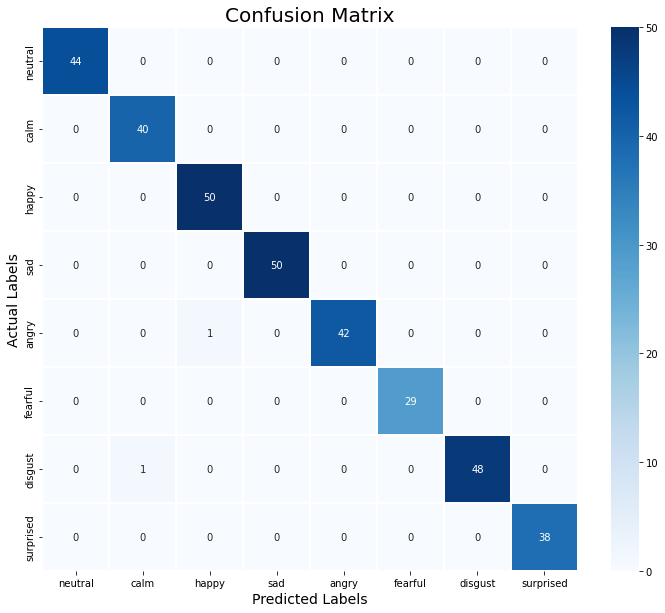

In [ ]:
cm = confusion_matrix(y_test_mel2d, y_pred)
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.categories_] , columns = [i for i in lb.categories_])
cm = pd.DataFrame(cm , index = [i for i in emotion] , columns = [i for i in emotion])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## 2d CNN (mfcc 2d)
- accuracy: 63.41%

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_mfcc2d_onehot = np_utils.to_categorical(lb.fit_transform(y_train_mfcc2d))
y_test_mfcc2d_onehot = np_utils.to_categorical(lb.fit_transform(y_test_mfcc2d))

In [ ]:
# print(y_train_mfcc2d_onehot)
# print(y_test_mfcc2d_onehot)
print(y_train_mfcc2d_onehot.shape)
print(y_test_mfcc2d_onehot.shape)

(1072, 8)
(358, 8)


In [ ]:
conv_model = convolutional_model((x_train_mfcc2d.shape[1], x_train_mfcc2d.shape[2], x_train_mfcc2d.shape[3]))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 282, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 40, 282, 8)        136       
                                                                 
 re_lu (ReLU)                (None, 40, 282, 8)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 36, 8)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 36, 16)         528       
                                                                 
 re_lu_1 (ReLU)              (None, 5, 36, 16)         0         
                                                             

In [ ]:
history = conv_model.fit(x_test_mfcc2d, y_test_mfcc2d_onehot, validation_data=(x_test_mfcc2d, y_test_mfcc2d_onehot), batch_size = 16, epochs=20)

Epoch 1/20
23/23 [==============================] - 13s 39ms/step - loss: 18.6043 - accuracy: 0.1285 - val_loss: 8.9621 - val_accuracy: 0.1676
Epoch 2/20
23/23 [==============================] - 0s 17ms/step - loss: 5.9060 - accuracy: 0.1620 - val_loss: 4.4855 - val_accuracy: 0.2011
Epoch 3/20
23/23 [==============================] - 0s 17ms/step - loss: 3.9778 - accuracy: 0.1927 - val_loss: 3.2965 - val_accuracy: 0.2039
Epoch 4/20
23/23 [==============================] - 0s 16ms/step - loss: 3.1236 - accuracy: 0.2346 - val_loss: 2.8626 - val_accuracy: 0.2542
Epoch 5/20
23/23 [==============================] - 0s 18ms/step - loss: 2.7206 - accuracy: 0.2654 - val_loss: 2.5511 - val_accuracy: 0.2682
Epoch 6/20
23/23 [==============================] - 0s 14ms/step - loss: 2.3820 - accuracy: 0.3017 - val_loss: 2.1831 - val_accuracy: 0.3324
Epoch 7/20
23/23 [==============================] - 0s 14ms/step - loss: 2.1805 - accuracy: 0.2905 - val_loss: 2.1190 - val_accuracy: 0.3659
Epoch 8/20


In [ ]:
temp = conv_model.evaluate(x_test_mfcc2d, y_test_mfcc2d_onehot)

12/12 [==============================] - 0s 7ms/step - loss: 1.0926 - accuracy: 0.6341


## 1d CNN 1d (mel + mfcc 1d)

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_onehot = np_utils.to_categorical(lb.fit_transform(y_train)) # one hot ?
y_test_onehot = np_utils.to_categorical(lb.fit_transform(y_test))

In [ ]:
# one hot encode the target 
lb = LabelEncoder()
y_train_mfcc1d_onehot = np_utils.to_categorical(lb.fit_transform(y_train_mfcc1d)) # one hot ?
y_test_mfcc1d_onehot = np_utils.to_categorical(lb.fit_transform(y_test_mfcc1d))

In [ ]:
x_train_expand = np.expand_dims(x_train, axis=-1)
x_test_expand = np.expand_dims(x_test, axis=-1)
print(x_train_expand.shape)
print(x_test_expand.shape)

(2878, 168, 1)
(960, 168, 1)


In [ ]:
x_train_mfcc1d = np.expand_dims(x_train_mfcc1d, axis=-1)
x_test_mfcc1d = np.expand_dims(x_test_mfcc1d, axis=-1)
print(x_train_mfcc1d.shape)
print(x_test_mfcc1d.shape)

(2877, 40, 1)
(960, 40, 1)


In [ ]:
Model=Sequential()
Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(Dropout(0.2))

Model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.3))

Model.add(Dense(units=8, activation='softmax'))

In [ ]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [ ]:
# early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [ ]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 84, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 84, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 42, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 42, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

In [ ]:
scaler_data = StandardScaler()

x_train_scale = scaler_data.fit_transform(x_train)
x_test_scale = scaler_data.transform(x_test)

print(x_train.shape)
print(x_train_scale.shape)

(8638, 168)
(8638, 168)


In [ ]:
history = Model.fit(x_train_scale, y_train_onehot, batch_size=32, epochs=50, validation_data=(x_test_scale, y_test_onehot))

In [ ]:
temp = Model.evaluate(x_test_scale, y_test_onehot)

### loss & acc plot, heat map
- Q) train acc < test acc? - small training set?

In [ ]:
print("Accuracy of our model on test data : " , Model.evaluate(x_test_scale, y_test_onehot)[1]*100 , "%")
epochs = 50

epochs = [i for i in range(epochs)] # epoch!
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [ ]:
lb = LabelEncoder()
emotion = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']
lb.fit(emotion)

pred_test = Model.predict(x_test_scale)

# print(pred_test.shape)
# print(np.argmax(pred_test, axis = 1))
# print(np.argmax(pred_test, axis = 1).shape)

pred_test = np.argmax(pred_test, axis = 1)
y_pred = lb.inverse_transform(pred_test) ## number -> string (emotion)

# print(y_pred.shape) # (358,)
# print(y_test_mel2d.shape) # list. 358

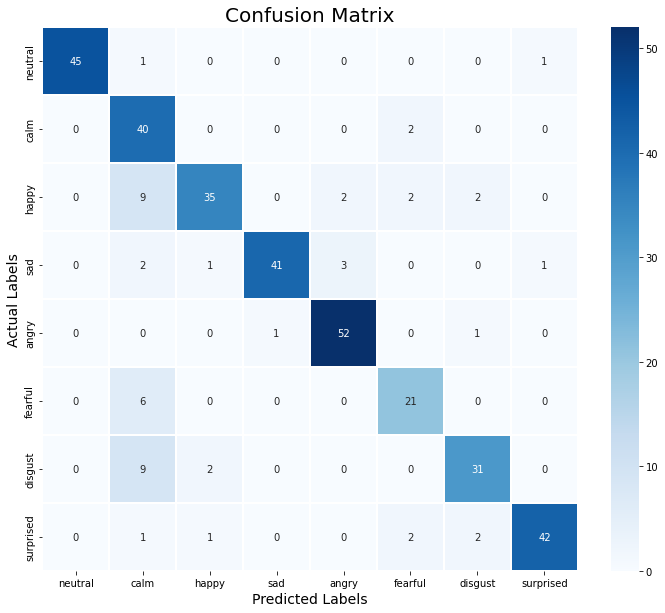

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
# cm = pd.DataFrame(cm , index = [i for i in lb.categories_] , columns = [i for i in lb.categories_])
cm = pd.DataFrame(cm , index = [i for i in emotion] , columns = [i for i in emotion])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

## MLP (mffc & mel 1d, mean)
- accuracy: 50.56%



In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train, y_train) # 2 sec

In [ ]:
# Predict for the test set
y_pred = model.predict(x_test)

In [ ]:
# Calculate the accuracy of our model
accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 50.56%


## MLP (mfcc 1d, mean)
- accuracy 44.01%

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train_mfcc1d,y_train_mfcc1d) # 1 sec

In [ ]:
# Predict for the test set
y_pred_mfcc1d=model.predict(x_test_mfcc1d)

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_mfcc1d, y_pred=y_pred_mfcc1d)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 43.02%


## MLP (mel spectrogram 1d, flatten)

- accuracy : 38.55%

In [ ]:
# Initialize the Multi Layer Perceptron Classifier
model = MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

In [ ]:
# Train the model
clf = model.fit(x_train_mel1d, y_train_mel1d) # 3min 40 sec

In [ ]:
# Predict for the test set
y_pred_mel1d = model.predict(x_test_mel1d)

In [ ]:
# Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test_mel1d, y_pred=y_pred_mel1d)
# Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 38.55%
